In [1]:
# Libraries
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
#import scipy as sp
import scipy.ndimage

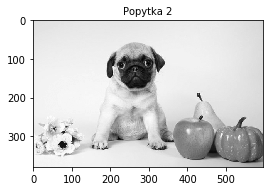

In [2]:
img = np.array(Image.open('tyazhelo.png'), dtype=np.float64)
plt.figure(figsize=(14,6))
plt.subplot(131)
plt.title('Popytka 2', fontsize=10)
plt.imshow(img, cmap=plt.cm.gray)
plt.show()

In [3]:
def approximate(img, eps): 
    n = 300
    u, s, v = np.linalg.svd(img)
    #n = -1
    img_appr = np.array(img)
    
    while np.linalg.norm(img_appr - img) / np.linalg.norm(img) < eps:
        img_appr = np.dot(u[:, :n] * s[:n], v[:n, :])
        n -= 1
    n += 2
    eps_rank = n
    img_appr = np.dot(u[:, :n] * s[:n], v[:n, :])
    return img_appr, eps_rank

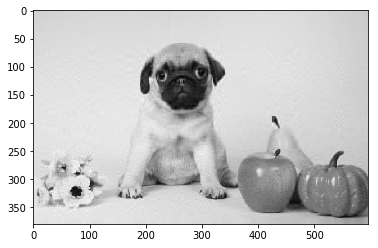

In [4]:
new_img, rank = approximate(img, 0.022)
plt.imshow(new_img, cmap=plt.cm.gray)
plt.show()

In [5]:
print (rank)

53


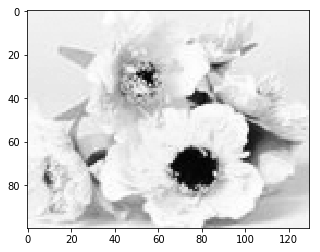

In [6]:
cropped_img = img[250:350, 0:130]

plt.imshow(cropped_img, cmap=plt.cm.gray)
plt.show()

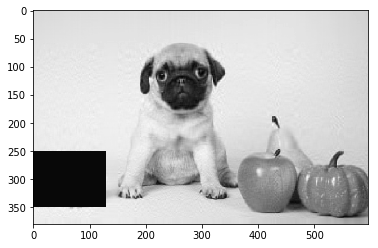

In [7]:
new_img[250:350, 0:130] =np.zeros((350-250, 130-0))
plt.imshow(new_img, cmap=plt.cm.gray)
plt.show()

In [8]:
import numpy as np
import scipy.sparse.linalg as spla
import scipy.sparse as sparse

class SoftInput():
    def __init__(self, X):
        self.X = X
        self.nonzero = self.X.nonzero()
        
    def fit(self, lambdas, maxiter, tol=1e-6, start_rank=100):
        self.rank = start_rank
        self.tol = tol
        self.lambdas = np.sort(lambdas)[::-1]
        self.Z_old = sparse.csr_matrix(self.X.shape)
        self.S_old = np.zeros((self.rank,))
        self.U_old = np.zeros((self.X.shape[0], self.rank))
        self.Vt_old = np.zeros((self.rank, self.X.shape[1]))
        
        self.filled = []
        
        for l in self.lambdas:
            for i in range(maxiter):
                proj_data = np.array(self.Z_old[self.nonzero]).flatten()
                self.Z_proj = sparse.csr_matrix((proj_data, self.nonzero), shape=self.X.shape)
                lin_op = spla.LinearOperator(self.X.shape,
                                             matvec=self.matvec,
                                             rmatvec=self.rmatvec)
                U, S, Vt = spla.svds(lin_op, self.rank)
                S -= l
                S = S[S > 0]
                
                #print(S.size, S.min())
                self.rank = S.shape[0]
                U = U[:, :self.rank]
                Vt = Vt[:self.rank, :]
                self.U_old = U
                self.Vt_old = Vt
                self.S_old = S
                self.Z_new = U.dot(np.diag(S).dot(Vt))
                # TODO: compute Frobenius norm with no explicit computations of Z
                if (np.linalg.norm(self.Z_new - self.Z_old) ** 2 / np.linalg.norm(self.Z_new) ** 2 < self.tol):
                    self.Z_old = self.Z_new
                    print('converged')
                    break
                self.Z_old = self.Z_new
            self.filled.append(self.Z_old)
        
        return self.lambdas, self.filled

    def matvec(self, vec):
        res = self.X.dot(vec) - self.Z_proj.dot(vec)
        res += self.U_old.dot(np.diag(self.S_old).dot(self.Vt_old.dot(vec)))
        return res
    
    def rmatvec(self, vec):
        res = self.X.T.dot(vec) - self.Z_proj.T.dot(vec)
        res += self.Vt_old.T.dot(np.diag(self.S_old).dot(self.U_old.T.dot(vec)))
        return res

In [9]:
X = sparse.csr_matrix(new_img)

In [10]:
soft_input = SoftInput(X)

In [16]:
lambdas = np.linspace(0, 100, 10)
print(lambdas)
lambdas, approximations = soft_input.fit(lambdas=lambdas, maxiter=1000000, start_rank=rank, tol=1e-10)

[   0.           11.11111111   22.22222222   33.33333333   44.44444444
   55.55555556   66.66666667   77.77777778   88.88888889  100.        ]
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged


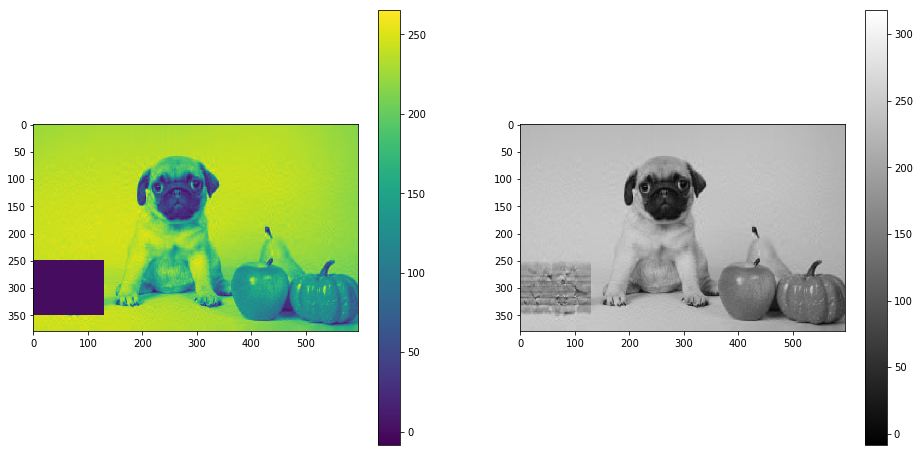

In [17]:
plt.figure(figsize=(16, 8))

plt.subplot(121)
plt.imshow(X.toarray())
plt.colorbar()

plt.subplot(122)
plt.imshow(approximations[-1], cmap=plt.cm.gray)
plt.colorbar()
plt.show()